# Task 2

---

## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [2]:
import numpy as np
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, precision_recall_curve, roc_curve
from imblearn.over_sampling import ADASYN
from sweetviz import analyze
%matplotlib inline

In [3]:
df = pd.read_csv("data/customer_booking.csv", encoding="ISO-8859-1")
df.head()

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   flight_hour flight_day   route booking_origin  wants_extra_baggage  \
0            7        Sat  AKLDEL    New Zealand                    1   
1            3        Sat  AKLDEL    New Zealand                    0   
2           17        Wed  AKLDEL          India                    1   
3            4        Sat  AKLDEL    New Zealand                    0   
4           15        Wed  AKLDEL          India                    1   

   wants_preferred_seat  wants_in_flight_meals  flight_duration  \
0                     0                      0             5.52   
1                     0                      0             5.52   
2                     1                      0             5.52   
3                     0                      1             5.52   
4                     0                      1             5.52   

   booking_complete  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0

The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [4]:
df.shape

(50000, 14)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [6]:
df["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [7]:
mapping = {
    "Mon": 1,
    "Tue": 2,
    "Wed": 3,
    "Thu": 4,
    "Fri": 5,
    "Sat": 6,
    "Sun": 7,
}

df["flight_day"] = df["flight_day"].map(mapping)

In [8]:
df["flight_day"].unique()

array([6, 3, 4, 1, 7, 2, 5], dtype=int64)

In [9]:
df.describe()

num_passengers  purchase_lead  length_of_stay  flight_hour  \
count    50000.000000   50000.000000     50000.00000  50000.00000   
mean         1.591240      84.940480        23.04456      9.06634   
std          1.020165      90.451378        33.88767      5.41266   
min          1.000000       0.000000         0.00000      0.00000   
25%          1.000000      21.000000         5.00000      5.00000   
50%          1.000000      51.000000        17.00000      9.00000   
75%          2.000000     115.000000        28.00000     13.00000   
max          9.000000     867.000000       778.00000     23.00000   

         flight_day  wants_extra_baggage  wants_preferred_seat  \
count  50000.000000         50000.000000          50000.000000   
mean       3.814420             0.668780              0.296960   
std        1.992792             0.470657              0.456923   
min        1.000000             0.000000              0.000000   
25%        2.000000             0.000000              0.000000   
50%        4.000000             1.000000              0.000000   
75%        5.000000             1.000000              1.000000   
max        7.000000             1.000000              1.000000   

       wants_in_flight_meals  flight_duration  booking_complete  
count           50000.000000     50000.000000      50000.000000  
mean                0.427140         7.277561          0.149560  
std                 0.494668         1.496863          0.356643  
min                 0.000000         4.670000          0.000000  
25%                 0.000000         5.620000          0.000000  
50%                 0.000000         7.570000          0.000000  
75%                 1.000000         8.830000          0.000000  
max                 1.000000         9.500000          1.000000

The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

From this point, you should continue exploring the dataset with some visualisations and other metrics that you think may be useful. Then, you should prepare your dataset for predictive modelling. Finally, you should train your machine learning model, evaluate it with performance metrics and output visualisations for the contributing variables. All of this analysis should be summarised in your single slide.

In [10]:
ba_dataframe = df.copy()

In [11]:
analz=analyze(ba_dataframe)

                                             |                                             | [  0%]   00:00 ->…


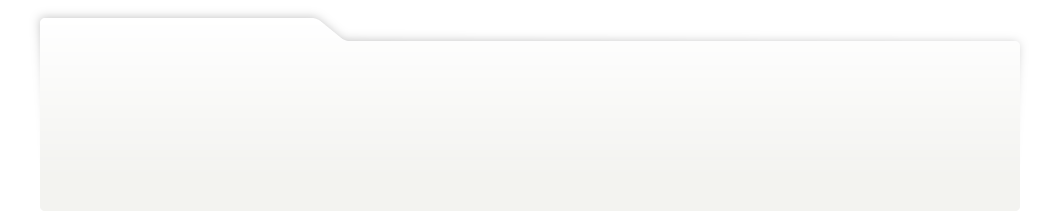
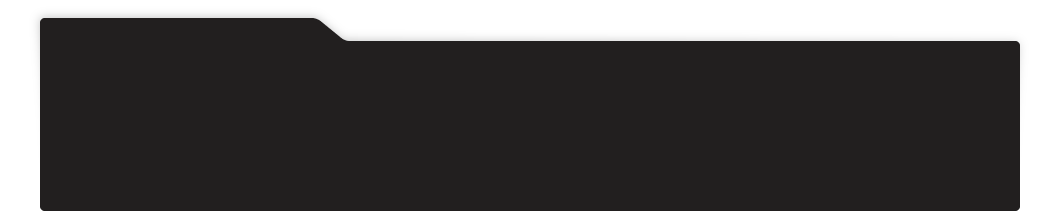
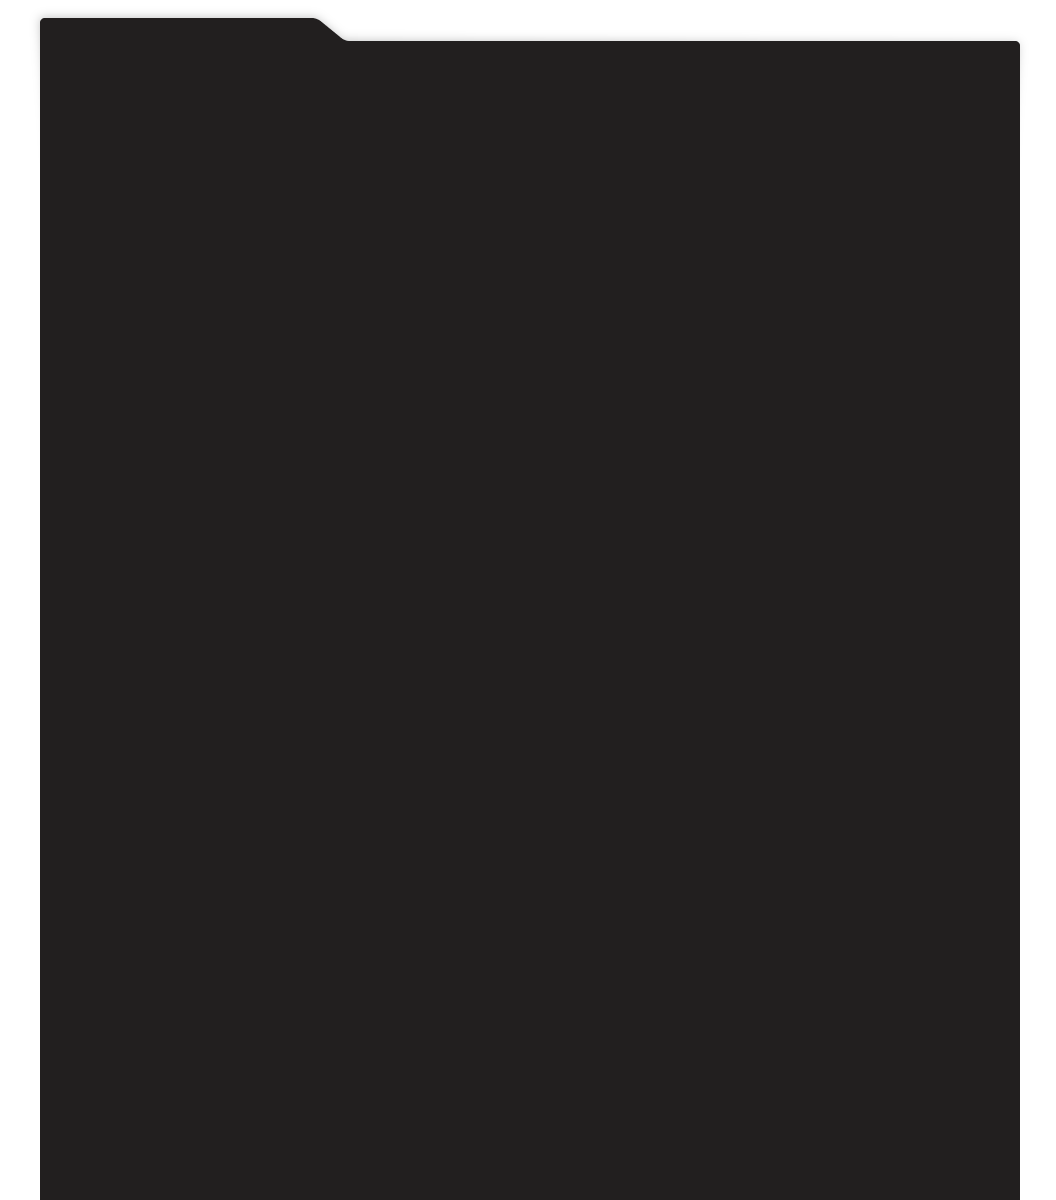
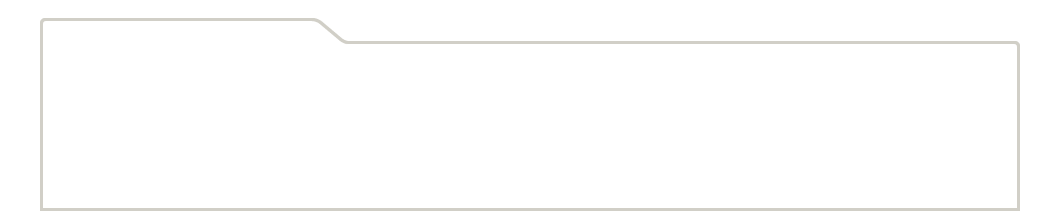
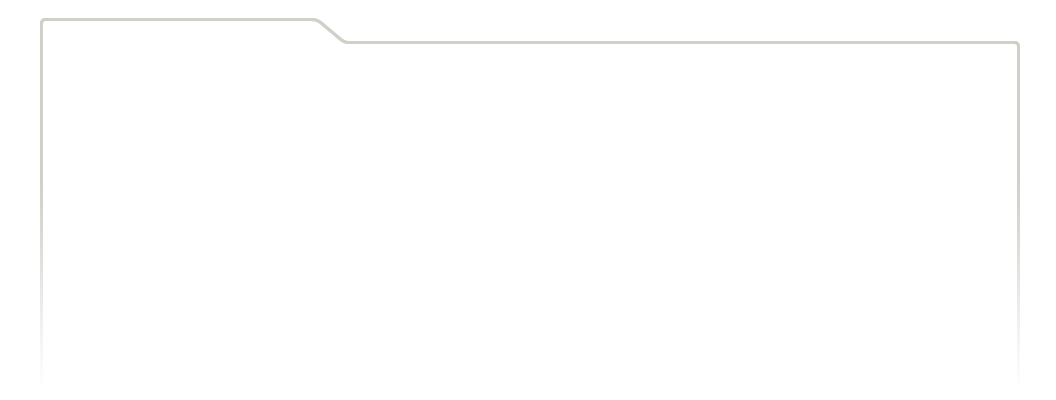
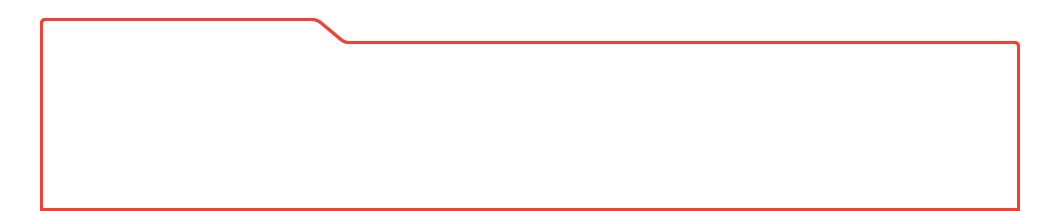
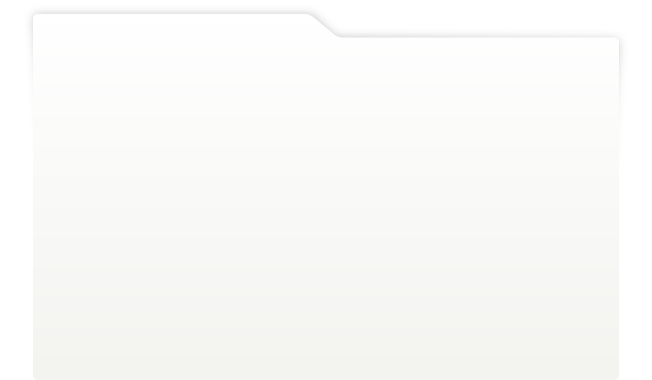
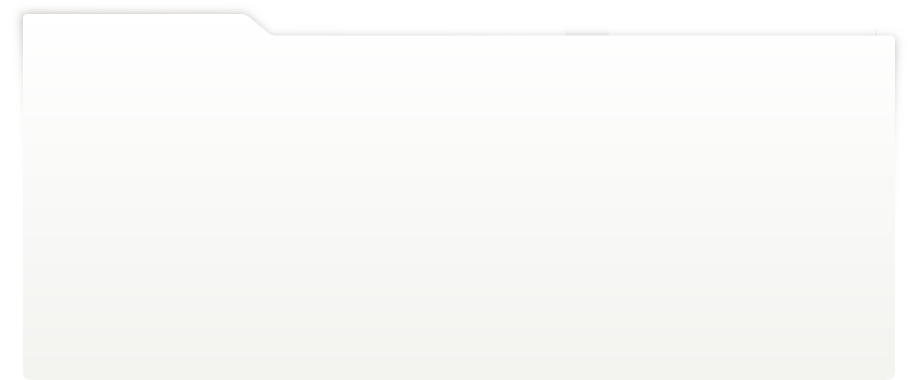
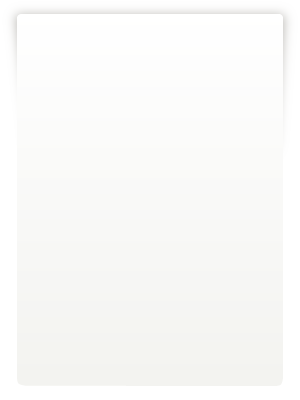
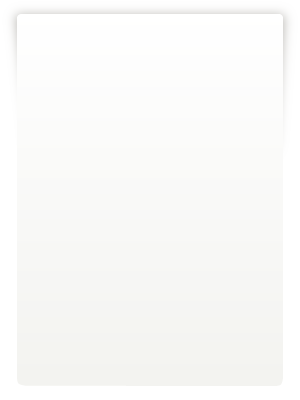
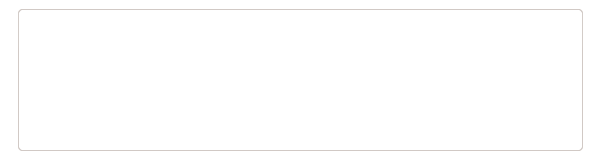
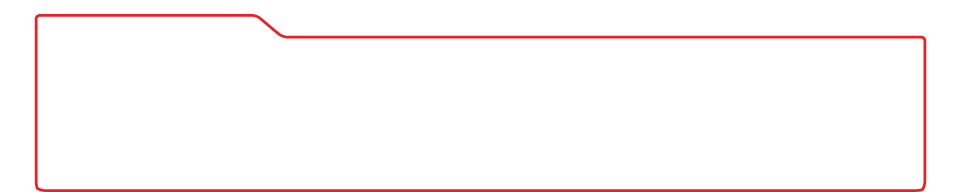
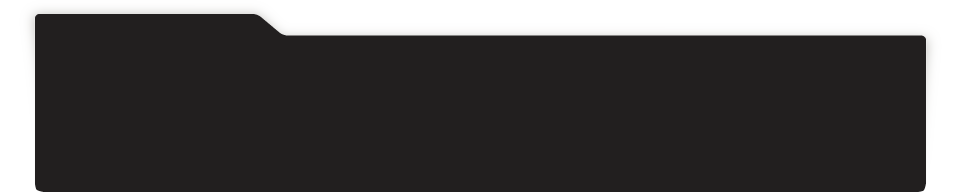
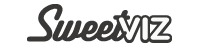
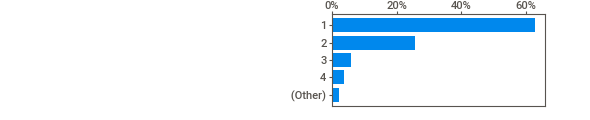
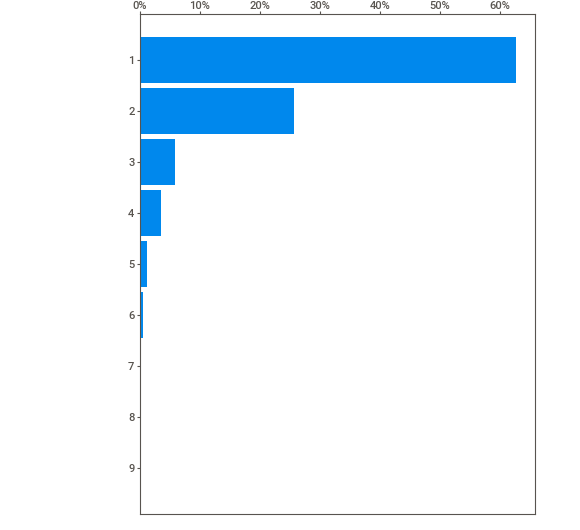
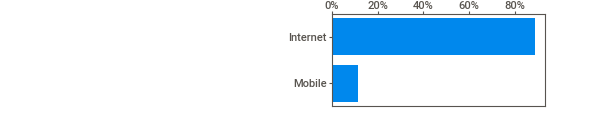
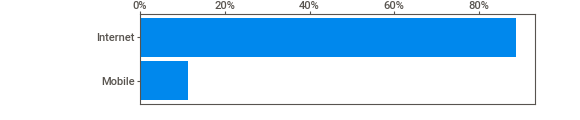
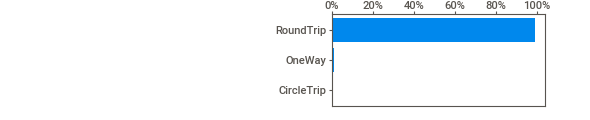
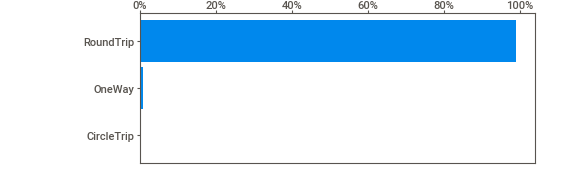
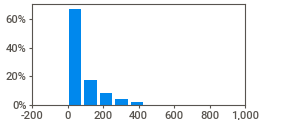
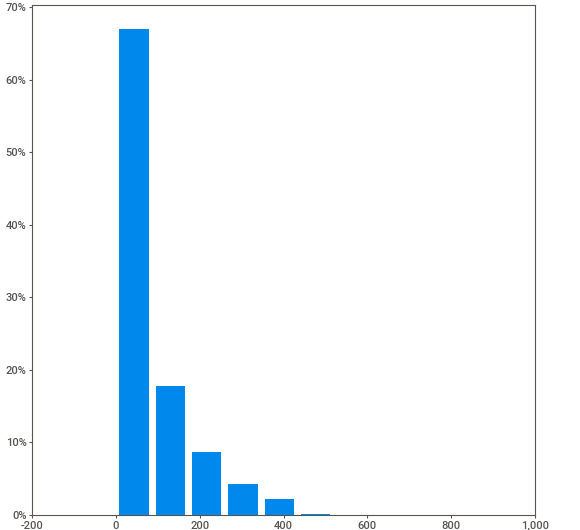
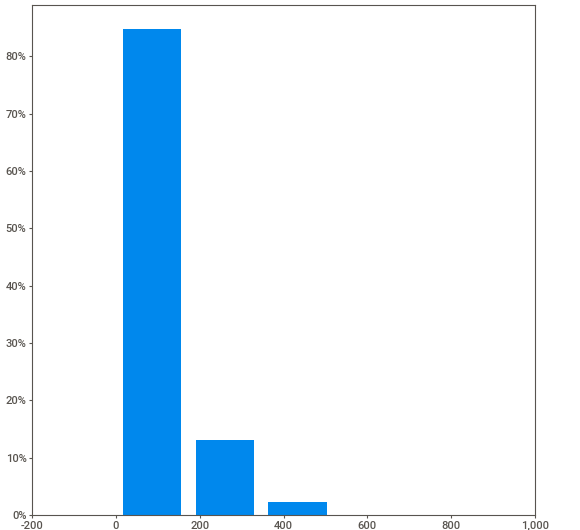
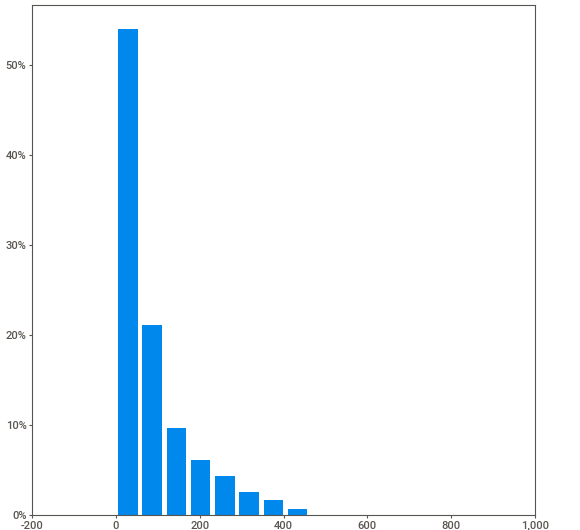
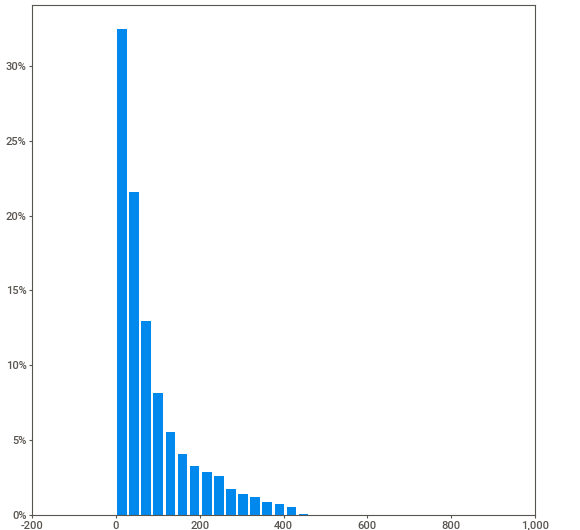
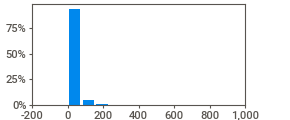
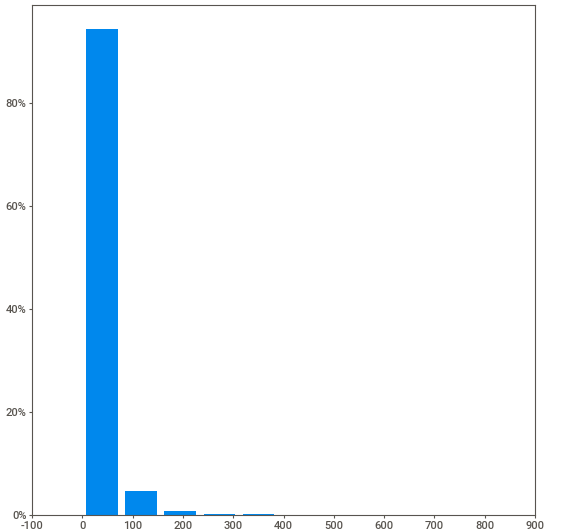
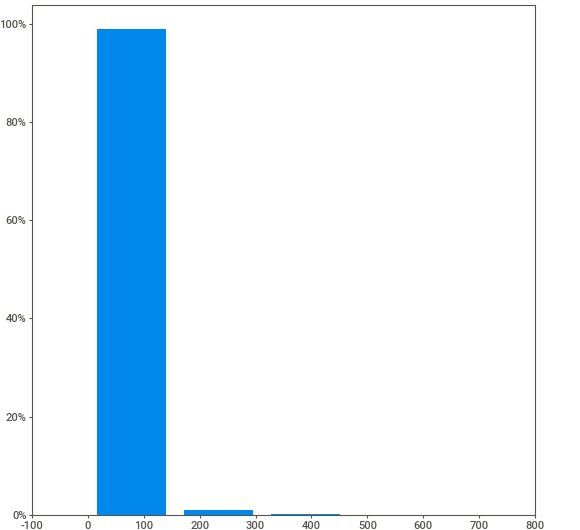
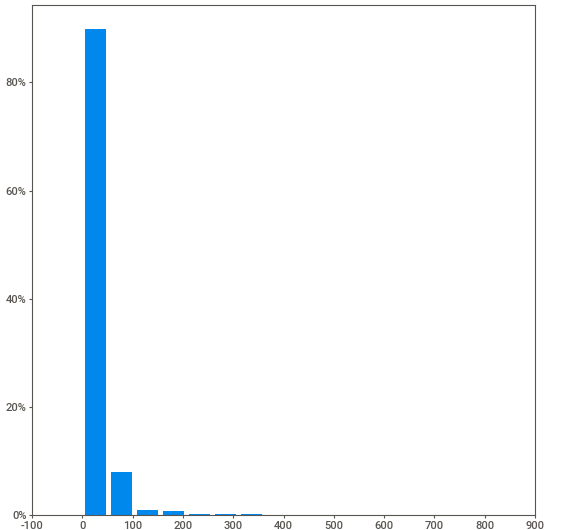
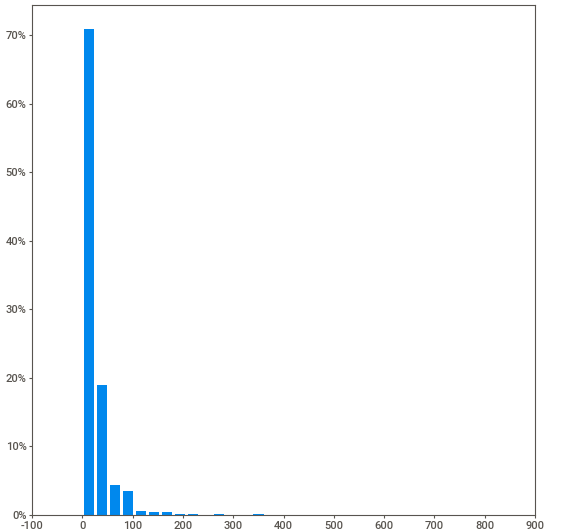
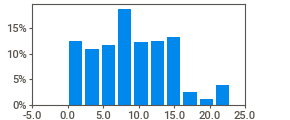
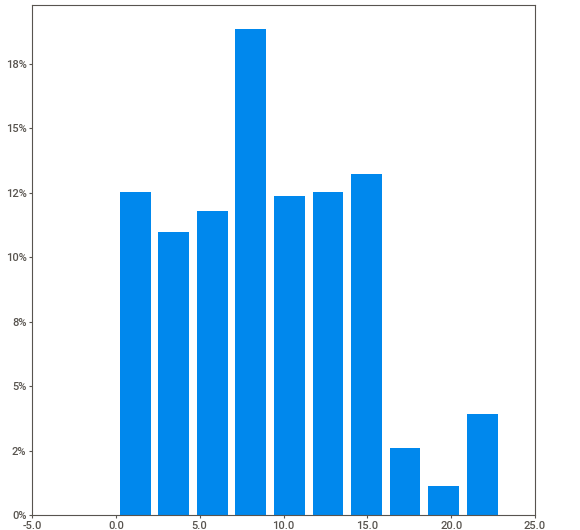
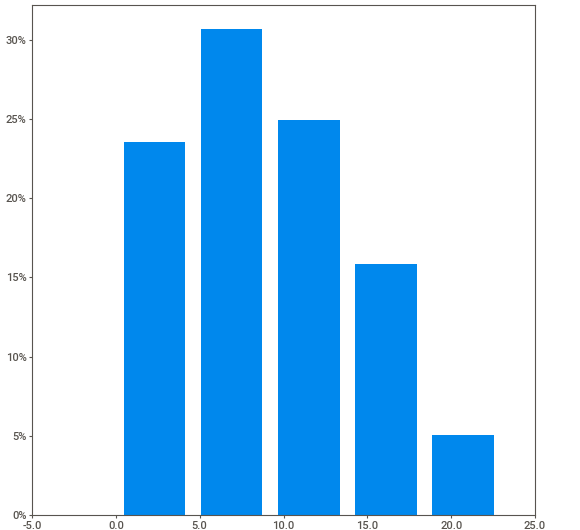
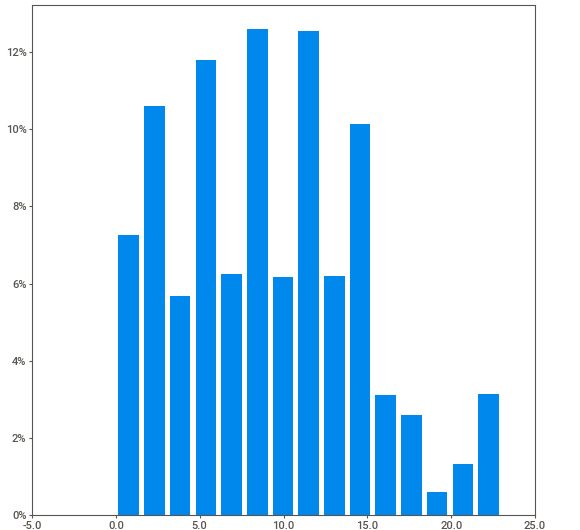
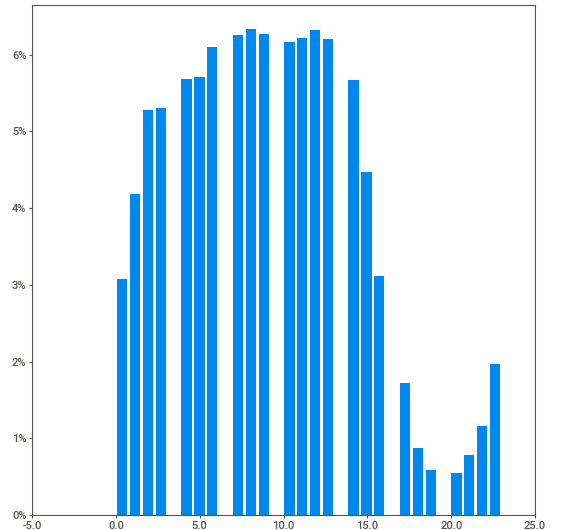
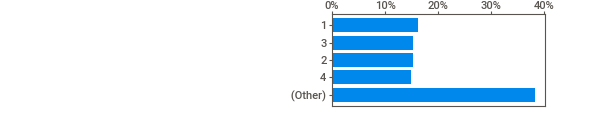
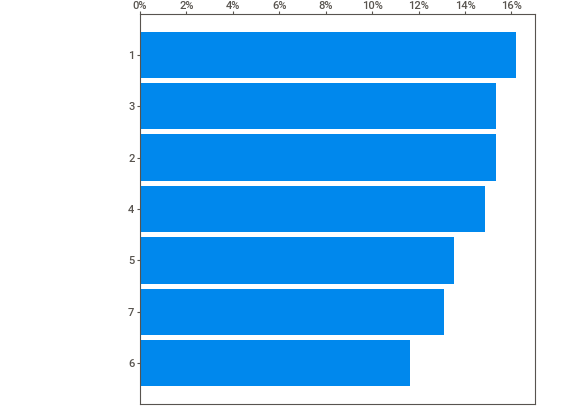
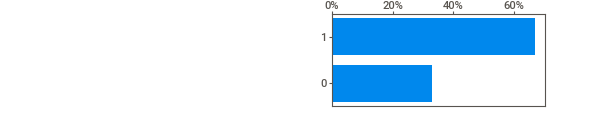
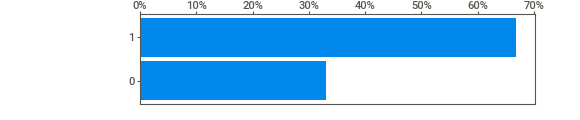
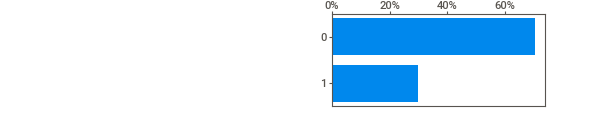
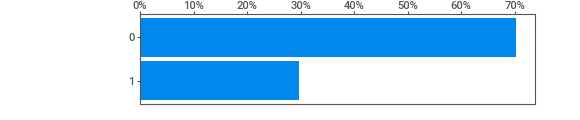
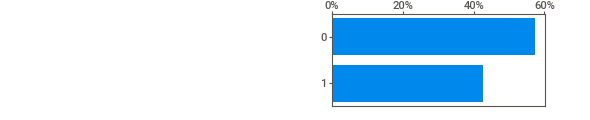
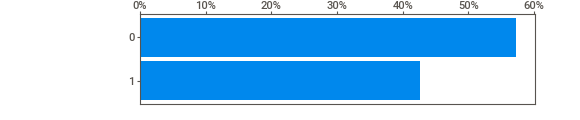
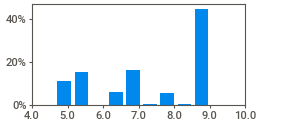
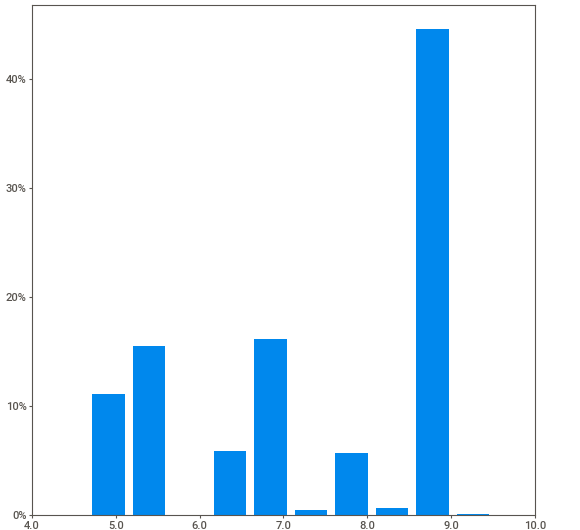
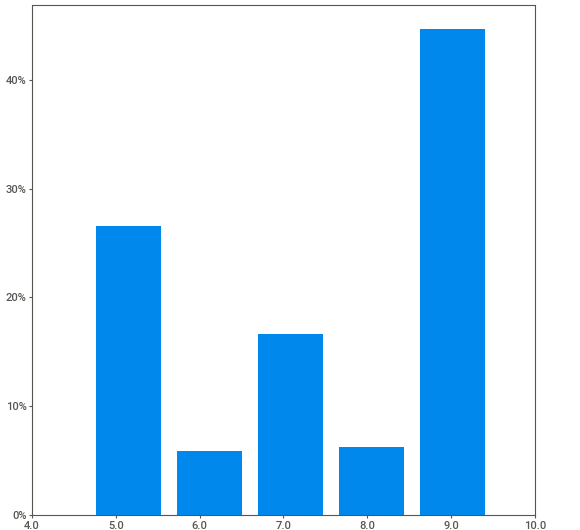
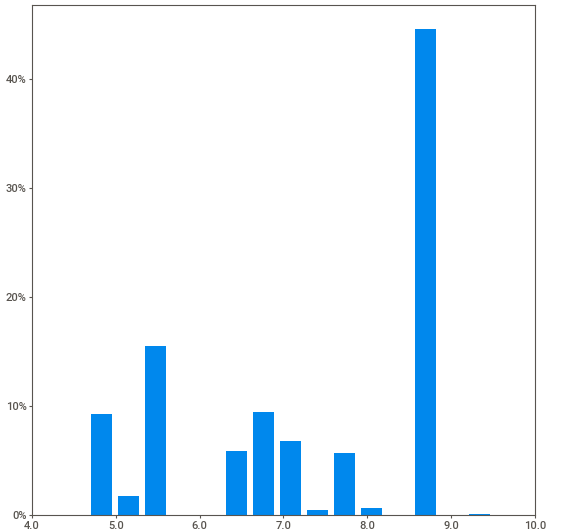
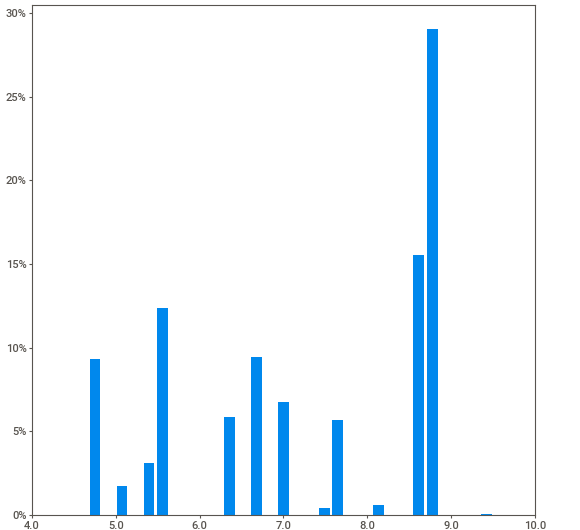
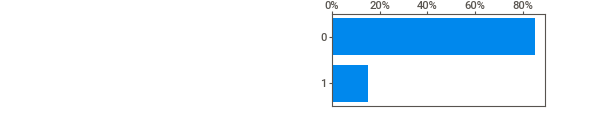
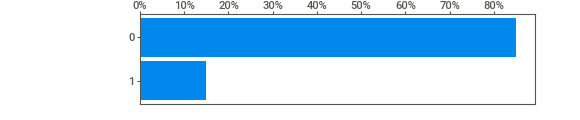
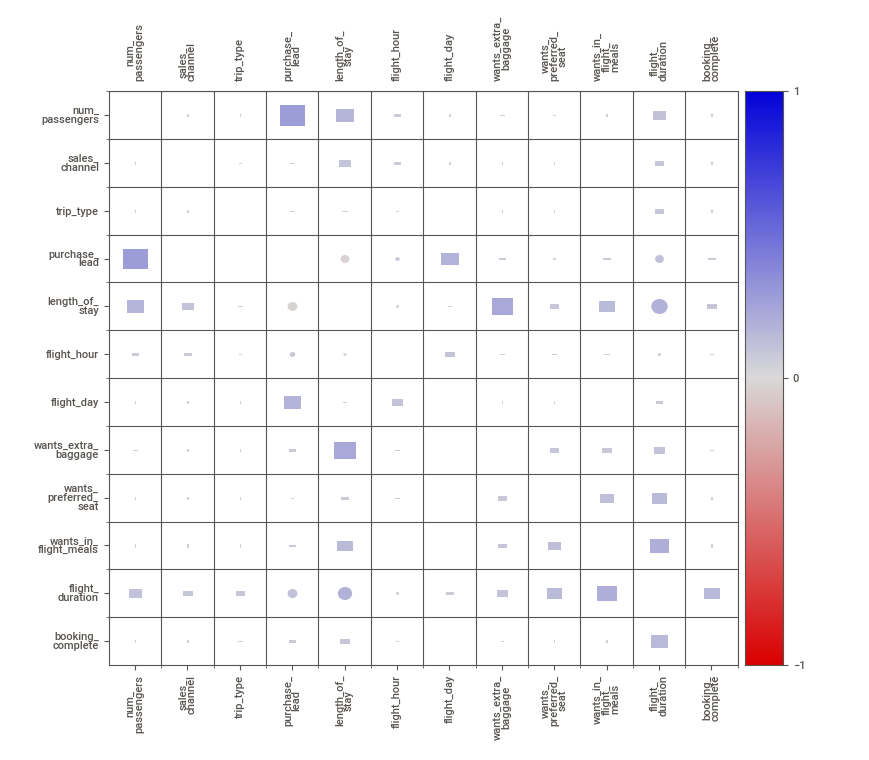
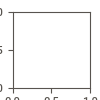

In [12]:
analz.show_notebook()

In [13]:
ba_dataframe.nunique()

num_passengers             9
sales_channel              2
trip_type                  3
purchase_lead            470
length_of_stay           335
flight_hour               24
flight_day                 7
route                    799
booking_origin           104
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

In [14]:
ba_dataframe["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [15]:
px.histogram(data_frame=ba_dataframe, x="trip_type", color="booking_complete")

In [16]:
px.histogram(data_frame=ba_dataframe, x="sales_channel", color="booking_complete")

<Axes: xlabel='wants_in_flight_meals', ylabel='Count'>

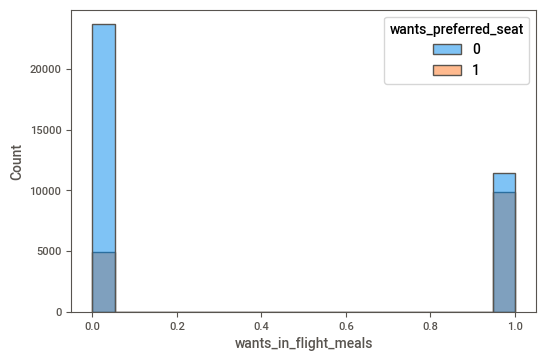

In [17]:
sns.histplot(data=ba_dataframe, x="wants_in_flight_meals", hue="wants_preferred_seat")

<Axes: xlabel='flight_hour', ylabel='Count'>

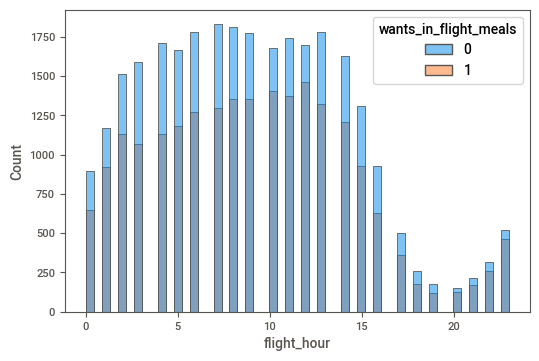

In [18]:
sns.histplot(data=ba_dataframe, x="flight_hour", hue="wants_in_flight_meals")

<Axes: xlabel='flight_day', ylabel='Count'>

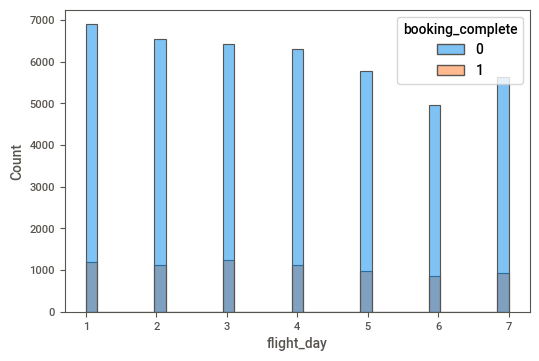

In [19]:
sns.histplot(data=ba_dataframe, x="flight_day", hue="booking_complete")

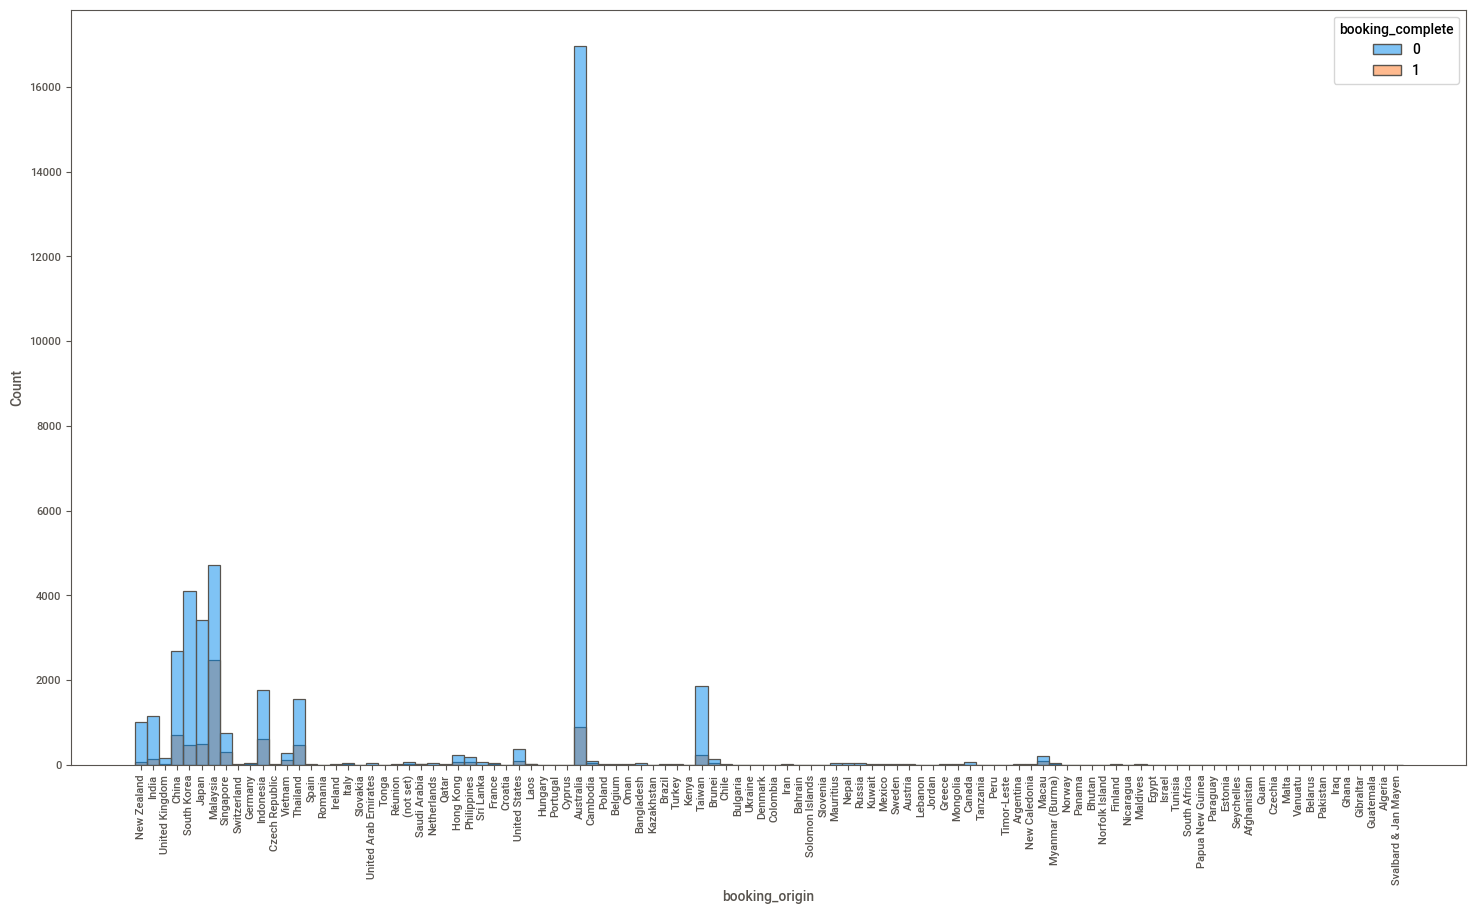

In [20]:
plt.figure(figsize=(18,10))
sns.histplot(data=ba_dataframe, x="booking_origin", hue="booking_complete")
plt.xticks(rotation=90)
plt.show()

In [21]:
for origin in ba_dataframe["booking_origin"]:
    if origin == "Iraq":
        print("found it")

found it


In [22]:
origin_list = []
target_list = ["Australia", "Malaysia", "South Korea", "Japan", "China"]

for origin in ba_dataframe["booking_origin"]:
    if origin in target_list:
        origin_list.append(origin)
    else:
        origin_list.append("Others")
origin_list

['Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'Others',
 'China',
 'Others',
 'South Korea',
 'Others',
 'South Korea',
 'Others',
 'South Korea',
 'South Korea',
 'Others',
 'South Korea',
 'Others',
 'Others',
 'South Korea',
 'Others',
 'Others',
 'Others',
 'Others',
 'South Korea',
 'South Korea',
 'Others',
 'South Korea',
 'South Korea',
 'South Korea',
 'South Korea',
 'Others',
 'South Korea',
 'Others',
 'South Korea',
 'South Korea',
 'South Korea',
 'Others',
 'Others',
 'Others',
 'South Korea',
 'South Korea',
 'South Korea',
 'South Korea',
 'South Korea',
 'Others',
 'Others',
 'South Korea',
 'South Korea',
 'Others',
 'South Korea',
 'Others',
 'South Korea',
 'Others',
 'South Korea',
 'South Korea',
 'South Korea',
 'Japan',
 'Japan',
 'Others',
 'Others',
 'Japan',
 'Japan',
 'Others',
 'Others',
 'Others',
 'Other

In [23]:
ba_dataframe["booking_origin"] = origin_list

In [24]:
ba_dataframe["booking_origin"].value_counts()

booking_origin
Australia      17872
Others         13123
Malaysia        7174
South Korea     4559
Japan           3885
China           3387
Name: count, dtype: int64

In [25]:
mapping = {
    "Australia": 1,
    "Others": 2,
    "Malaysia": 3,
    "South Korea": 4,
    "Japan": 5,
    "China": 6,
}

ba_dataframe["booking_origin"] = ba_dataframe["booking_origin"].map(mapping)

In [26]:
ba_dataframe["booking_origin"].value_counts()

booking_origin
1    17872
2    13123
3     7174
4     4559
5     3885
6     3387
Name: count, dtype: int64

<Axes: >

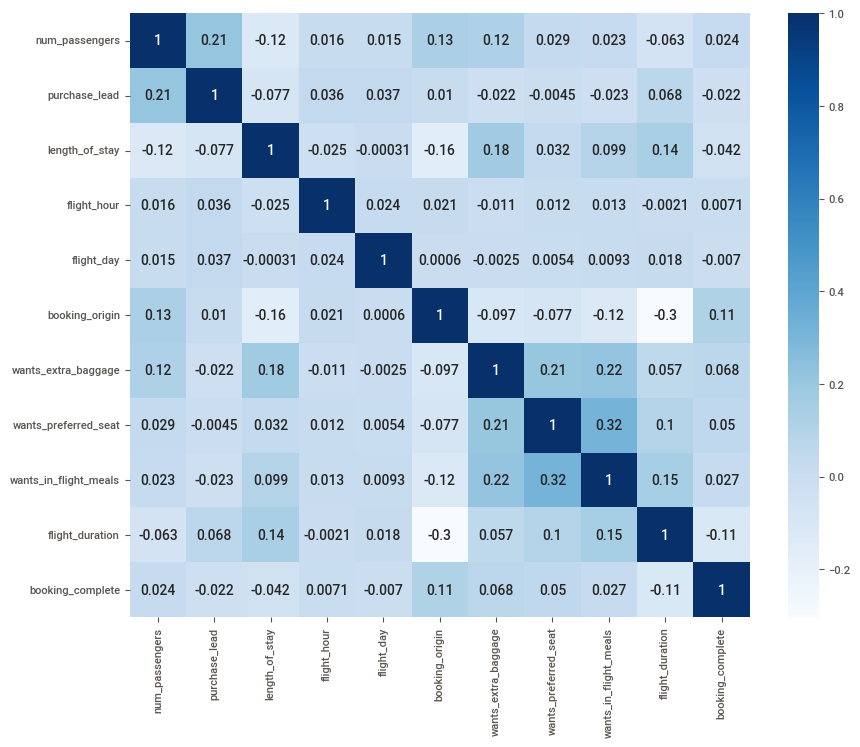

In [27]:
cor = ba_dataframe.corr(numeric_only=True)
plt.figure(figsize=(10,8))
sns.heatmap(cor, annot=True, fmt=".2g", cmap="Blues")

In [28]:
ba_data = ba_dataframe.drop(["route", "flight_hour", "flight_day"], axis=1)
ba_data.head()

num_passengers sales_channel  trip_type  purchase_lead  length_of_stay  \
0               2      Internet  RoundTrip            262              19   
1               1      Internet  RoundTrip            112              20   
2               2      Internet  RoundTrip            243              22   
3               1      Internet  RoundTrip             96              31   
4               2      Internet  RoundTrip             68              22   

   booking_origin  wants_extra_baggage  wants_preferred_seat  \
0               2                    1                     0   
1               2                    0                     0   
2               2                    1                     1   
3               2                    0                     0   
4               2                    1                     0   

   wants_in_flight_meals  flight_duration  booking_complete  
0                      0             5.52                 0  
1                      0             5.52                 0  
2                      0             5.52                 0  
3                      1             5.52                 0  
4                      1             5.52                 0

In [29]:
X = ba_data.drop("booking_complete", axis=1)
y = ba_data.booking_complete

In [30]:
ct = ColumnTransformer([("ohe", OneHotEncoder(), ["sales_channel","trip_type"])], remainder = 'passthrough')
X_ohe = ct.fit_transform(X)
X_ohe

array([[1.  , 0.  , 0.  , ..., 0.  , 0.  , 5.52],
       [1.  , 0.  , 0.  , ..., 0.  , 0.  , 5.52],
       [1.  , 0.  , 0.  , ..., 1.  , 0.  , 5.52],
       ...,
       [1.  , 0.  , 0.  , ..., 0.  , 1.  , 5.62],
       [1.  , 0.  , 0.  , ..., 0.  , 1.  , 5.62],
       [1.  , 0.  , 0.  , ..., 1.  , 0.  , 5.62]])

In [31]:
X_ohe.shape

(50000, 13)

In [32]:
y.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

In [33]:
imb = ADASYN(random_state=42)
X_res, y_res = imb.fit_resample(X_ohe, y)

In [34]:
y_res.value_counts()

booking_complete
1    43099
0    42522
Name: count, dtype: int64

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [36]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)

In [37]:
X_test = scaler.transform(X_test)

## Model

In [75]:
model = RandomForestClassifier()

In [76]:
clf = RandomizedSearchCV(model, {"n_estimators":[10, 20, 50, 100],
                                "criterion":["gini", "entropy", "log_loss"]}, cv=5)

In [77]:
clf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'criterion': ['gini', 'entropy',
                                                      'log_loss'],
                                        'n_estimators': [10, 20, 50, 100]})

In [78]:
clf.best_estimator_

RandomForestClassifier(criterion='entropy')

In [79]:
clf.best_params_

{'n_estimators': 100, 'criterion': 'entropy'}

In [80]:
clf.best_score_

0.898870006495226

In [81]:
best_model = clf.best_estimator_

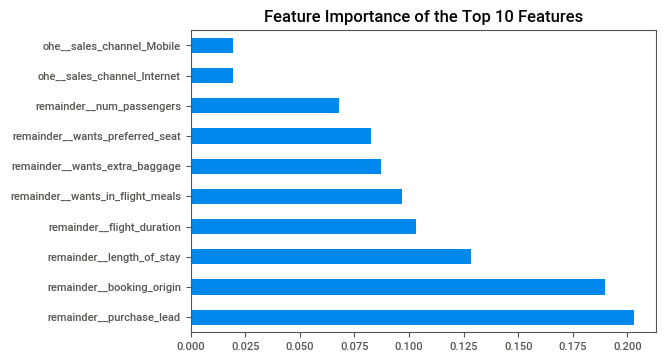

In [82]:
#show how important each of the features are
importances = pd.Series(best_model.feature_importances_, index=ct.get_feature_names_out())
importances.nlargest(10).plot(kind='barh')
plt.title("Feature Importance of the Top 10 Features")
plt.show()

### Evaluation with the Train Set

In [83]:
cross_val = cross_val_score(model, X_train, y_train, cv=10)

In [84]:
cross_val.mean()

0.8993955620352697

In [85]:
cross_val

array([0.89912409, 0.89985401, 0.90262774, 0.89620438, 0.89868613,
       0.90145985, 0.90071543, 0.89940137, 0.89735728, 0.89852533])

In [86]:
#Plot the confusion matrix. Set Normalize = True/False
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap="Greens"):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    class_number = len(classes)
    tick_marks = np.arange(class_number)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=2)
        cm[np.isnan(cm)] = 0.0
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

In [87]:
y_pred_train = best_model.predict(X_train)
y_pred_train

array([1, 0, 1, ..., 1, 0, 0], dtype=int64)

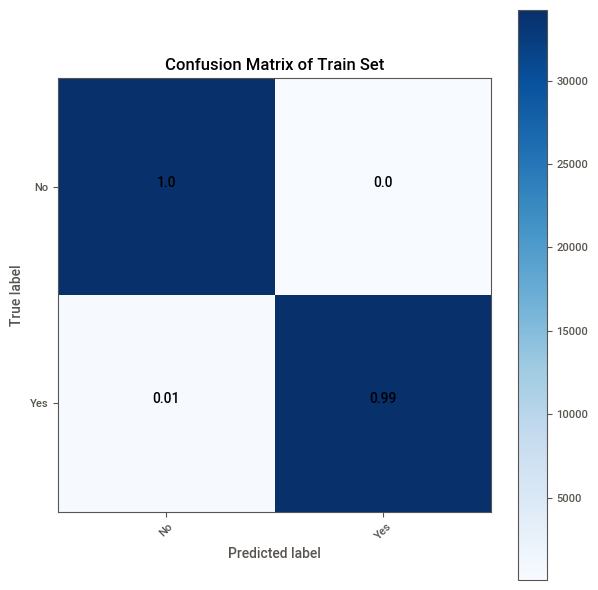

In [88]:
classes = ["No", "Yes"]
cm = confusion_matrix(y_train, y_pred_train)
plot_confusion_matrix(cm, classes, normalize=True, title = "Confusion Matrix of Train Set", cmap="Blues")

In [89]:
print(classification_report(y_train, y_pred_train))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00     34052
           1       1.00      0.99      1.00     34444

    accuracy                           1.00     68496
   macro avg       1.00      1.00      1.00     68496
weighted avg       1.00      1.00      1.00     68496



In [90]:
print(round(precision_score(y_train, y_pred_train)*100,2))

99.81


In [91]:
print(round(recall_score(y_train, y_pred_train)*100,2))

99.39


In [92]:
print(round(f1_score(y_train, y_pred_train)*100,2))

99.6


In [93]:
y_probs_train = cross_val_predict(best_model, X_train, y_train, cv=10, method="predict_proba")
y_probs_train

array([[0.  , 1.  ],
       [0.96, 0.04],
       [0.  , 1.  ],
       ...,
       [0.  , 1.  ],
       [0.9 , 0.1 ],
       [0.83, 0.17]])

In [94]:
y_scores_train  = y_probs_train[:, 1]
precision, recall, threshold = precision_recall_curve(y_train, y_scores_train)

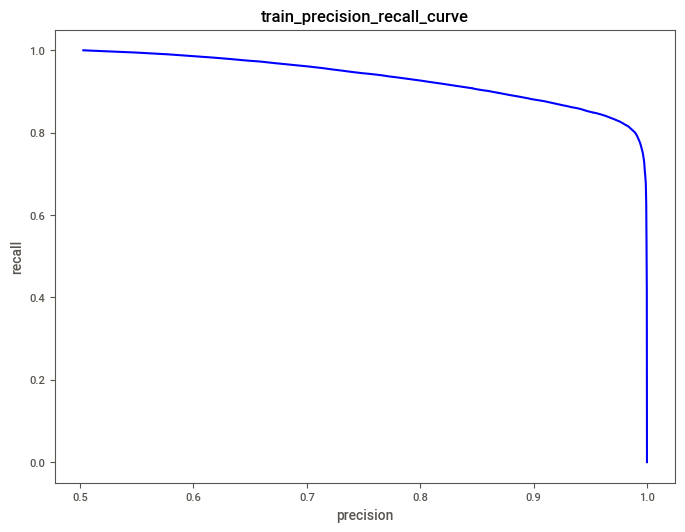

In [95]:
plt.figure(figsize=(8,6))
plt.plot(precision, recall, "b")
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("train_precision_recall_curve")
plt.show()

In [96]:
fpr, tpr, threshold = roc_curve(y_train, y_scores_train)

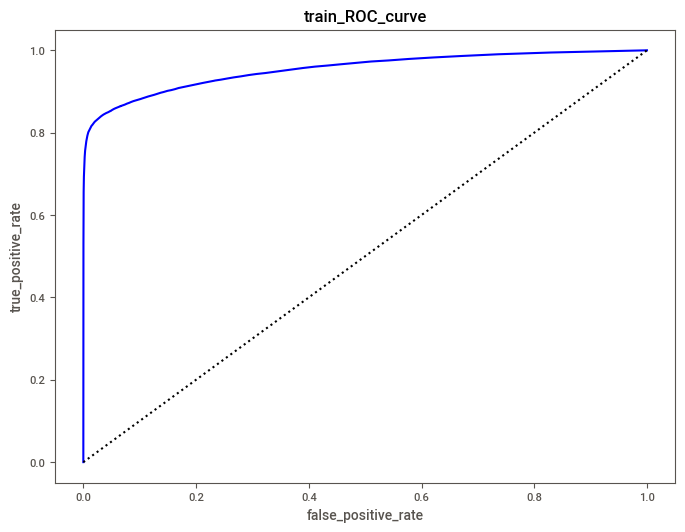

In [97]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel("false_positive_rate")
plt.ylabel("true_positive_rate")
plt.title("train_ROC_curve")
plt.show()

In [98]:
print(round(roc_auc_score(y_train, y_scores_train)*100, 2))

95.36


### Evaluation with the Test Set

In [99]:
y_pred = best_model.predict(X_test)
y_pred

array([1, 1, 0, ..., 1, 1, 1], dtype=int64)

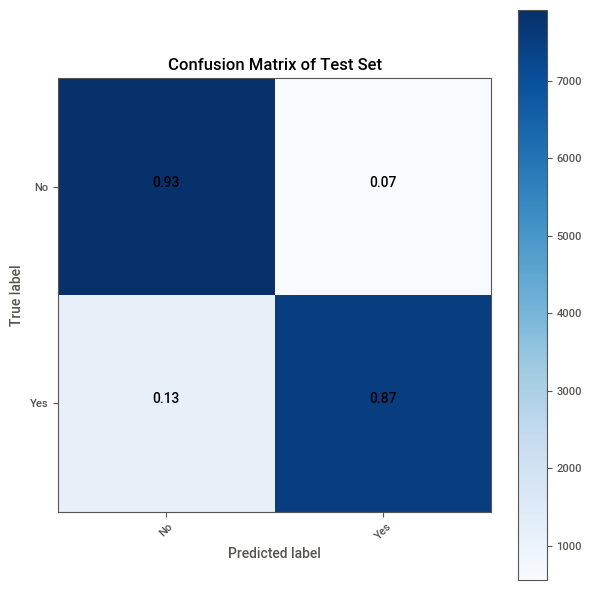

In [100]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes, normalize=True, title = "Confusion Matrix of Test Set", cmap="Blues")

In [101]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90      8470
           1       0.93      0.87      0.90      8655

    accuracy                           0.90     17125
   macro avg       0.90      0.90      0.90     17125
weighted avg       0.90      0.90      0.90     17125



In [102]:
print(round(precision_score(y_test, y_pred)*100,2))

93.11


In [103]:
print(round(recall_score(y_test, y_pred)*100,2))

86.62


In [104]:
print(round(f1_score(y_test, y_pred)*100,2))

89.75


In [105]:
y_probs = cross_val_predict(best_model, X_test, y_test, cv=10, method="predict_proba")
y_probs

array([[0.05, 0.95],
       [0.26, 0.74],
       [0.56, 0.44],
       ...,
       [0.06, 0.94],
       [0.02, 0.98],
       [0.42, 0.58]])

In [106]:
y_scores  = y_probs[:, 1]

In [107]:
precision, recall, threshold = precision_recall_curve(y_test, y_scores)

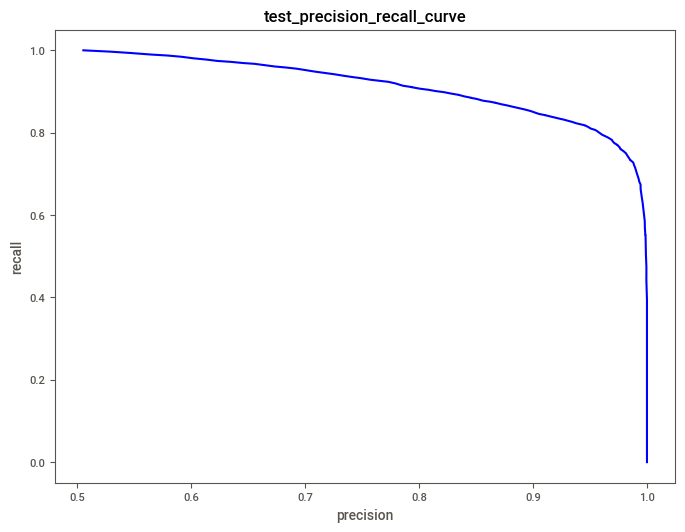

In [108]:
plt.figure(figsize=(8,6))
plt.plot(precision, recall, "b")
plt.xlabel("precision")
plt.ylabel("recall")
plt.title("test_precision_recall_curve")
plt.show()

In [109]:
fpr, tpr, threshold = roc_curve(y_test, y_scores)

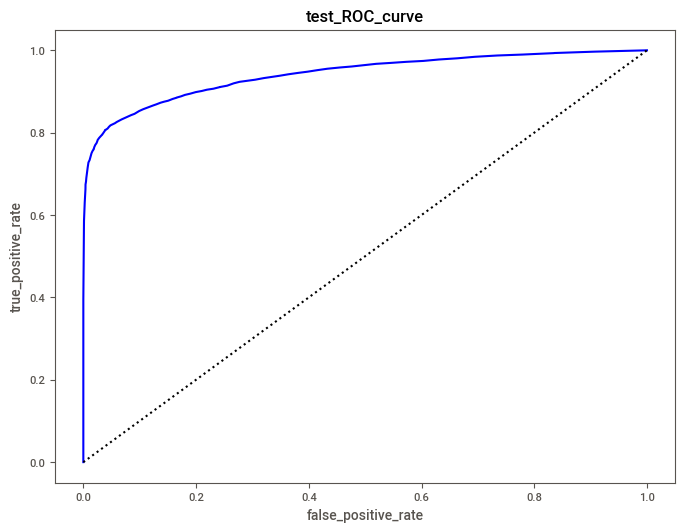

In [110]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, "b")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel("false_positive_rate")
plt.ylabel("true_positive_rate")
plt.title("test_ROC_curve")
plt.show()

In [111]:
print(round(roc_auc_score(y_test, y_scores)*100, 2))

94.15
